In [2]:
## Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

## Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

## 
import odor_stat_calculations as osc
import pandas as pd 
import os
import numpy as np

## scipy gaussian regressor 
import scipy
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
import linear_operator.settings as losettings
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

## bayesian optimization 
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report

from joblib import load, dump

### BINARY TRAINING

In [89]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 50
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Done


In [88]:
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# test_df = pd.read_hdf(test_file_path)

# gp = trained_models[test_file_path]
# scaler = scalers[test_file_path]

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Scale the test features
# X_test_scaled = scaler.transform(X_test)

# # Make predictions using the retrieved GP model
# y_pred_mean, y_pred_std = gp.predict(X_test_scaled, return_std=True)
# y_pred_binary = np.where(y_pred_mean > 3, 10, 0)  # Use a threshold of 5 to classify 0 or 10

# accuracy = accuracy_score(y_true, y_pred_binary)
# report = classification_report(y_true, y_pred_binary)
# print(f"Accuracy: {accuracy}")
# print(f"Classification report: {report}")

# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=test_df['odor_binary'], cmap='coolwarm', vmin=0, vmax=10)
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Presence')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=y_pred_binary, cmap='coolwarm', vmin=0, vmax=10)
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Presence')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')

# f.tight_layout()

In [90]:
# Function to apply Box-Cox transformation
def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data
    transformed_data, lambda_ = scipy.stats.boxcox(data_shifted)
    return transformed_data, lambda_, shift

# Function to calculate weighted average
def linear_decay(distance, max_distance=2):
    return max(0, (max_distance - distance) / max_distance)

def get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2):
    weights_sum = 0
    weighted_sum = 0
    for dx in np.arange(-max_distance, max_distance + 0.1, 1.0):
        for dy in np.arange(-max_distance, max_distance + 0.1, 1.0):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, _ = grid_stats[(neighbor_x, neighbor_y)]
                weights_sum += weight
                weighted_sum += weight * neighbor_mean
    if weights_sum > 0:
        return weighted_sum / weights_sum
    else:
        return np.nan  

def train_temporal_model(df, grid_stats):
    df = df.reset_index(drop=True)
    n_bins_x = 100
    n_bins_y = 100
    x_bin_edges = np.linspace(df['distance_along_streakline'].min(), df['distance_along_streakline'].max(), n_bins_x + 1)
    y_bin_edges = np.linspace(df['nearest_from_streakline'].min(), df['nearest_from_streakline'].max(), n_bins_y + 1)
    df['x_bin'] = pd.cut(df['distance_along_streakline'], bins=x_bin_edges, labels=False, include_lowest=True, right=True)
    df['y_bin'] = pd.cut(df['nearest_from_streakline'], bins=y_bin_edges, labels=False, include_lowest=True, right=True)

    df['odor_transformed'], lambda_, shift = apply_boxcox(df.odor)

    for i in range(n_bins_x):
        for j in range(n_bins_y):
            grid_data = df[(df['x_bin'] == i) & (df['y_bin'] == j)]['odor_transformed']
            if not grid_data.empty:
                grid_mean = grid_data.mean()
                grid_std = grid_data.std()
                grid_stats[(i, j)] = (grid_mean, grid_std)
    
    return lambda_, shift, grid_stats

# Concatenate data for temporal model training
combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

# Train the temporal model on combined data
grid_stats = {}
lambda_, shift, grid_stats = train_temporal_model(combined_df, grid_stats)


In [91]:
# Predicting temporal values based on spatial presence
new_test_df = pd.read_hdf("/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5")
new_test_df = new_test_df.reset_index(drop=True)

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]

# Apply spatial predictions to new data
new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values
new_X_test_scaled = scaler.transform(new_X_test)
new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 3, 10, 0)  # Use a threshold of 3 to classify 0 or 10

n_bins_x = 100
n_bins_y = 100
x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

predictions = []

for index, row in new_test_df.iterrows():
    x_bin, y_bin = row['x_bin'], row['y_bin']
    if new_y_pred_binary[index] == 10:  # Only apply temporal model to locations with odor presence
        mean = get_weighted_average(x_bin, y_bin, grid_stats, max_distance=0.5)
        predictions.append(mean)
    else:
        predictions.append(np.nan)

predictions = np.array(predictions)

if shift != 0:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_) - shift
else:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_)

predictions_filled = np.nan_to_num(predictions_original, nan=0) 

# Ensure consistency in length of arrays
min_length = min(len(new_test_df['distance_along_streakline']), len(predictions_filled))
new_test_df = new_test_df.iloc[:min_length]
predictions_filled = predictions_filled[:min_length]


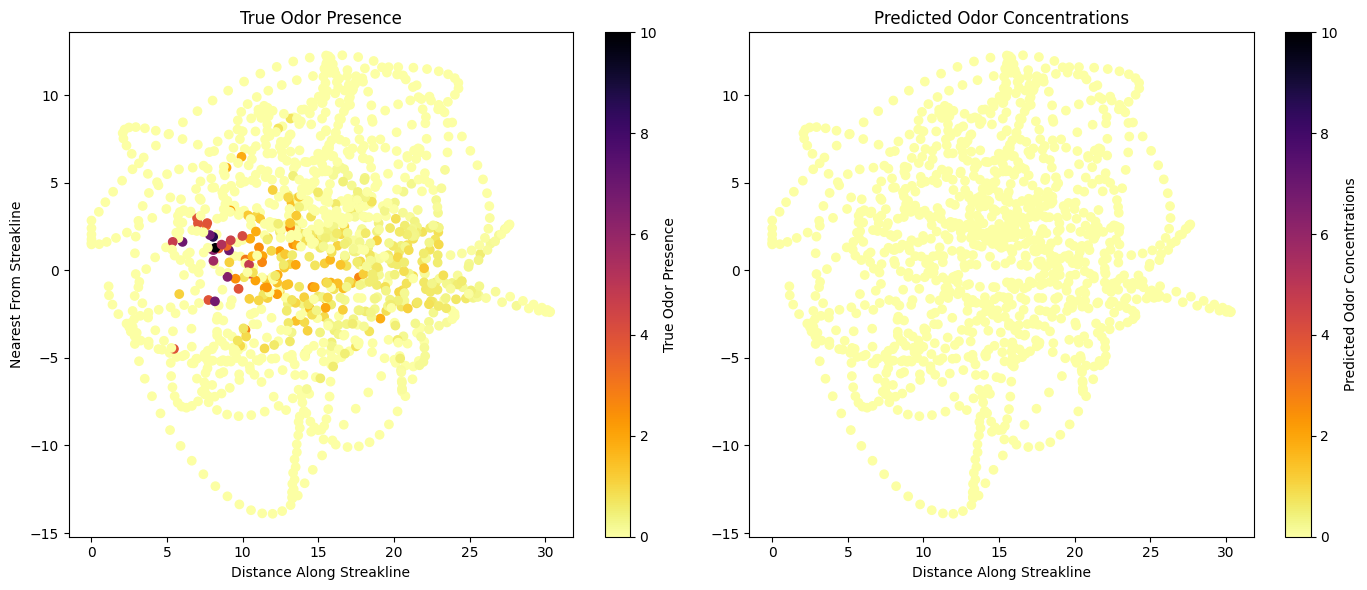

In [94]:

# Visualize the results
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# True Odor Presence (Binary)
sc1 = axes[0].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=new_test_df['odor'], cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Presence')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Concentrations (Continuous)
sc2 = axes[1].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=predictions_filled, cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Concentrations')
axes[1].set_title('Predicted Odor Concentrations')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
plt.show()


### ONLY USING SCIPY GPR

#### Binary Training

In [8]:
# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

# Combine all data for training a single GPR model
folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)
combined_df['odor_binary'] = combined_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Subsample the combined data for faster training
data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor_binary'].values  

# Initialize the MinMaxScaler
use_scaler = True  # Set this to False if you don't want to use the scaler

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

# Train the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
gp.fit(X_scaled, y)

# Save the trained model and scaler
trained_model = gp
trained_scaler = scaler

print("Spatial Model Training Done")

In [5]:
# import joblib

# model_filename = 'trained_model_may29_binary.joblib'
# scaler_filename = 'trained_scaler_may29_binary.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

Model saved to trained_model_may29_binary.joblib
Scaler saved to trained_scaler_may29_binary.joblib


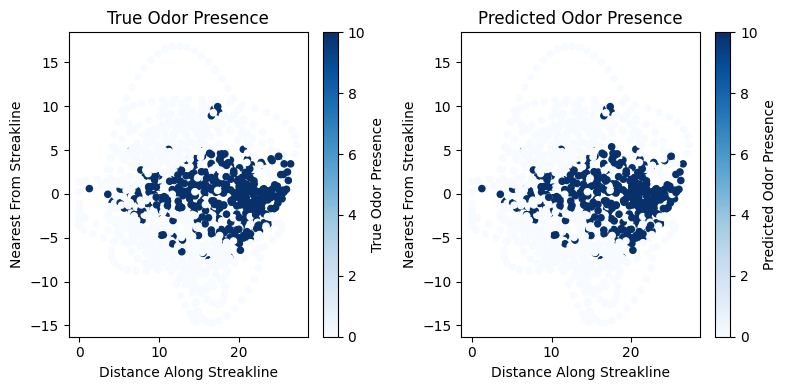

In [4]:
# Predicting spatial values using the combined GPR model
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag20.h5"
new_test_df = pd.read_hdf(test_file_path)
new_test_df = new_test_df.reset_index(drop=True)

new_test_df['odor_binary'] = new_test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Use the combined trained model and scaler
gp = trained_model
scaler = trained_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 5, 10, 0)  # Use a threshold of 3 to classify 0 or 10

# Visualize the results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor_binary'], cmap='Blues', s=20)
plt.colorbar(label='True Odor Presence')
plt.title('True Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_binary, cmap='Blues', s=20)
plt.colorbar(label='Predicted Odor Presence')
plt.title('Predicted Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


### Using Scipy GPR to train multiple datasets and predict continous values

In [36]:
## Windy
# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

## NotWindy
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/NotWindyForSim.h5')

query = 'odor>=1'
df_new = df.query(q)

In [37]:
df_new.reset_index(inplace=True, drop=True) 

In [38]:
df_new

,master_time,xsrc,ysrc,odor,trisonica_u,trisonica_v,trisonica_pressure,trisonica_temperature,gps_linear_x,gps_linear_y,...,distance_from_source,eastwest,northsouth,nearest_from_streakline,odorsim,relative_parallel_comp,relative_perpendicular_comp,ysign,xsign,distance_along_streakline
0,1.603220e+09,0.558421,-0.268425,6.540414,0.435176,-0.245815,885.700012,8.733802,-0.407857,0.024373,...,0.619585,-169.272949,4814.810044,-0.560069,0,0.760919,0.672970,-1,1.0,0.264968
1,1.603220e+09,0.516370,-0.261835,5.330735,0.154824,-0.568443,885.700012,8.606474,-0.405357,0.048374,...,0.578961,-169.333746,4814.807864,-0.473688,0,0.460591,-0.036325,-1,1.0,0.332890
2,1.603220e+09,0.317094,0.098547,7.145997,0.555928,-0.057784,885.700012,9.608504,0.010008,0.098040,...,0.332054,-170.111531,4812.945341,-0.250712,0,0.398774,0.103180,-1,1.0,0.217723
3,1.603220e+09,0.324655,0.102939,10.109440,0.579235,0.094353,885.799988,9.530529,-0.026161,-0.054820,...,0.340584,-170.152538,4812.925725,-0.218579,0,-0.421809,-0.265380,-1,1.0,0.261191
4,1.603220e+09,0.315944,0.092045,10.288665,0.481934,0.091178,885.799988,9.711934,-0.097163,-0.068821,...,0.329079,-170.100201,4812.927827,-0.262964,0,0.155661,-0.237510,-1,1.0,0.197846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5856,1.603229e+09,4.619372,2.019102,10.288665,1.941945,0.315063,883.599976,13.391995,-0.921271,-0.645176,...,5.041366,452.627121,304.319250,-1.112262,0,3.699489,0.234851,-1,1.0,4.917138
5857,1.603229e+09,4.315829,1.835748,10.288665,1.484628,-0.198611,883.599976,13.438963,-0.990093,-0.503275,...,4.690026,451.956235,303.893144,-1.040213,0,3.841237,0.237938,-1,1.0,4.573216
5858,1.603229e+09,4.218972,1.789932,5.038849,1.067892,-0.270139,883.645320,13.892525,-0.883684,-0.335632,...,4.582966,451.736375,303.727959,-1.006226,0,3.438094,0.921181,-1,1.0,4.471139
5859,1.603229e+09,4.129422,1.753255,10.288665,0.932907,-0.214515,883.654841,14.041939,-0.850683,-0.401634,...,4.486205,451.507415,303.600282,-0.912002,0,3.208670,1.300028,-1,1.0,4.392526


In [59]:
df_test = df_new[4000:]
df_test.reset_index(inplace=True, drop=True) 

In [48]:
df_extracted = df_new[:4000]

In [58]:
df_test_cont=df[4000:]
df_test_cont.reset_index(inplace=True, drop=True) 

Text(0.5, 1.0, 'HWS')

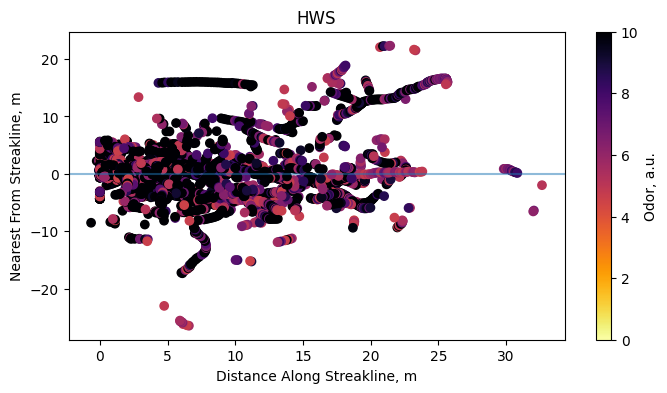

In [50]:
plt.figure(figsize=(8,4))
plt.scatter(df_extracted.distance_along_streakline, df_extracted.nearest_from_streakline,c=df_extracted.odor, cmap='inferno_r', vmin = 0, vmax = 10)
plt.axhline(0,0, alpha=0.5)
plt.xlabel('Distance Along Streakline, m')
plt.ylabel('Nearest From Streakline, m')
plt.colorbar(label='Odor, a.u.')
plt.title('HWS')

In [52]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))
lengthscale = 0.1
alpha = 0.263

# kernel = C(1.0, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))

kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))

# kernel = C(0.287**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))


# folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
# folder_path = "/home/gorilla/An/data/real_data_test/"
# all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

# combined_df=df[:3000]
combined_df = df_extracted

data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1) 

use_scaler = True  

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.11**2 * RBF(length_scale=0.01)
Spatial Model Training Done


In [188]:
# import joblib
# # Save the trained model and scalers
# model_filename = 'trained_model_jun3_modified_model1.joblib'
# scaler_filename = 'trained_model_jun3_modified_scaler1.joblib'
# target_scaler_filename = 'trained_model_jun3_modified_target_scaler1.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)
# joblib.dump(trained_target_scaler, target_scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")
# print(f"Target scaler saved to {target_scaler_filename}")

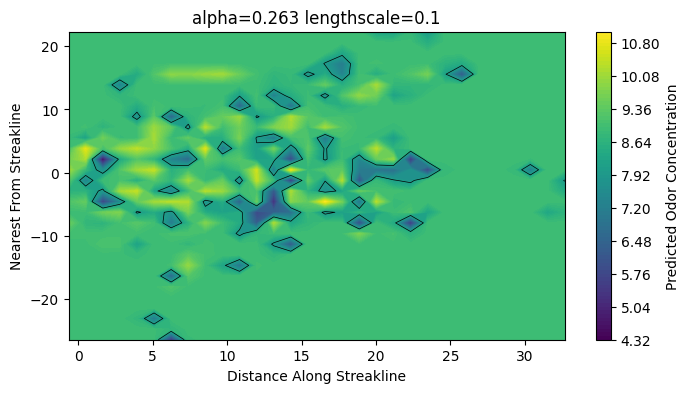

In [62]:
x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 30)
x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 30)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T

if scaler is not None:
    X_grid_scaled = scaler.transform(X_grid)
else:
    X_grid_scaled = X_grid

y_pred_scaled, y_std = gp.predict(X_grid_scaled, return_std=True)

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Visualization
plt.figure(figsize=(8, 4))
plt.contourf(X1, X2, y_pred.reshape(X1.shape), levels=100, cmap='viridis')
plt.colorbar(label='Predicted Odor Concentration')
plt.contour(X1, X2, y_pred.reshape(X1.shape), levels=1, colors='k', linewidths=0.5)
plt.title('alpha='+str(alpha)+' lengthscale='+str(lengthscale))
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')
plt.show()

In [55]:
# x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
# x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
# X1, X2 = np.meshgrid(x1, x2)
# X_grid = np.vstack([X1.ravel(), X2.ravel()]).T

# if scaler is not None:
#     X_grid_scaled = scaler.transform(X_grid)
# else:
#     X_grid_scaled = X_grid

# # Predict using the trained model
# y_pred_scaled, y_std = gp.predict(X_grid_scaled, return_std=True)

# # Inverse transform the predictions
# y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# # Contour plot for predicted data
# contour = ax.contourf(X1, X2, y_pred.reshape(X1.shape), levels=100, cmap='viridis')
# fig.colorbar(contour, ax=ax, label='Predicted Odor Concentration')
# ax.contour(X1, X2, y_pred.reshape(X1.shape), levels=10, colors='k', linewidths=0.5)

# # Overlay the actual data points
# ax.scatter(X[:, 0], X[:, 1], c='b',alpha=0.5, edgecolor='w', marker='o', s=50, label='Actual Data Points')

# ax.set_title('GP Predicted Odor Concentration with Actual Data Points')
# ax.set_xlabel('Distance Along Streakline')
# ax.set_ylabel('Nearest From Streakline')
# # ax.legend()
# fig.tight_layout()


In [56]:
# import joblib

# model_filename = 'trained_model_may29_cont.joblib'
# scaler_filename = 'trained_scaler_may29_cont.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

In [56]:
df_test

,master_time,xsrc,ysrc,odor,trisonica_u,trisonica_v,trisonica_pressure,trisonica_temperature,gps_linear_x,gps_linear_y,...,distance_from_source,eastwest,northsouth,nearest_from_streakline,odorsim,relative_parallel_comp,relative_perpendicular_comp,ysign,xsign,distance_along_streakline
0,1.603221e+09,-8.862764,-3.218106,10.288665,-0.029309,-1.310397,885.500000,8.732559,-0.161553,1.313913,...,9.428934,636.223543,4076.769671,-8.823776,0,-1.608298,-1.146356,-1,1.0,3.323517
1,1.603221e+09,-0.762743,-2.802273,10.288665,2.120993,0.281551,885.500000,9.085012,0.871714,0.234931,...,2.904223,634.499914,4089.299261,-1.255129,0,1.129448,0.650024,-1,1.0,2.619000
2,1.603221e+09,-0.640627,-3.023632,10.288665,2.384364,0.026954,885.500000,8.816044,-0.078005,-0.611863,...,3.090753,634.460866,4089.869378,-1.128763,0,0.391946,-0.029792,-1,1.0,2.877264
3,1.603221e+09,-4.485736,-12.749585,10.288665,1.076364,0.831818,885.500000,8.243636,0.466206,-0.788715,...,13.515685,630.170304,4120.048361,-5.005144,0,0.213343,0.094809,-1,1.0,12.554771
4,1.603221e+09,-4.437024,-12.828545,10.288665,1.251788,0.266899,885.500000,8.315037,0.468207,-0.747214,...,13.574195,630.126706,4120.150384,-4.996177,0,-0.401892,1.120376,-1,1.0,12.621291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,1.603229e+09,4.619372,2.019102,10.288665,1.941945,0.315063,883.599976,13.391995,-0.921271,-0.645176,...,5.041366,452.627121,304.319250,-1.112262,0,3.699489,0.234851,-1,1.0,4.917138
4857,1.603229e+09,4.315829,1.835748,10.288665,1.484628,-0.198611,883.599976,13.438963,-0.990093,-0.503275,...,4.690026,451.956235,303.893144,-1.040213,0,3.841237,0.237938,-1,1.0,4.573216
4858,1.603229e+09,4.218972,1.789932,5.038849,1.067892,-0.270139,883.645320,13.892525,-0.883684,-0.335632,...,4.582966,451.736375,303.727959,-1.006226,0,3.438094,0.921181,-1,1.0,4.471139
4859,1.603229e+09,4.129422,1.753255,10.288665,0.932907,-0.214515,883.654841,14.041939,-0.850683,-0.401634,...,4.486205,451.507415,303.600282,-0.912002,0,3.208670,1.300028,-1,1.0,4.392526


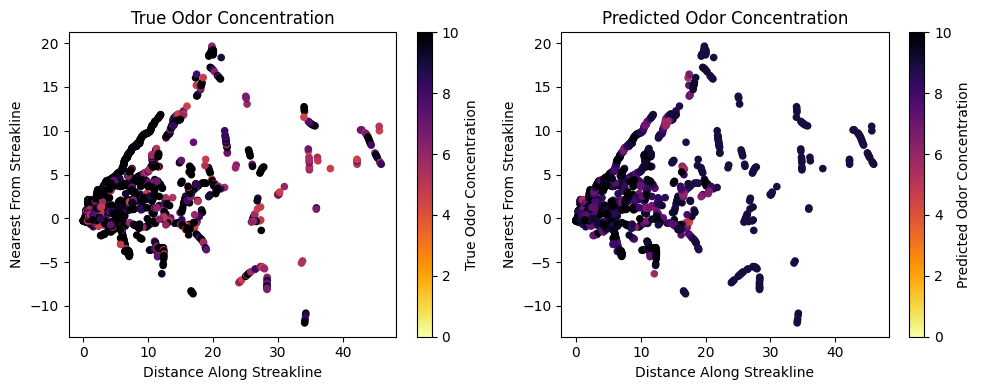

In [60]:
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/diag10.h5"
# new_test_df = pd.read_hdf(test_file_path)
# new_test_df = new_test_df.reset_index(drop=True)
new_test_df = df_test

gp = trained_model
scaler = trained_scaler
target_scaler = trained_target_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions to the original odor value scale
new_y_pred_mean = target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Clip the predictions to be within the range [0, 10]
new_y_pred_mean = np.clip(new_y_pred_mean, 0, 10)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_mean, cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


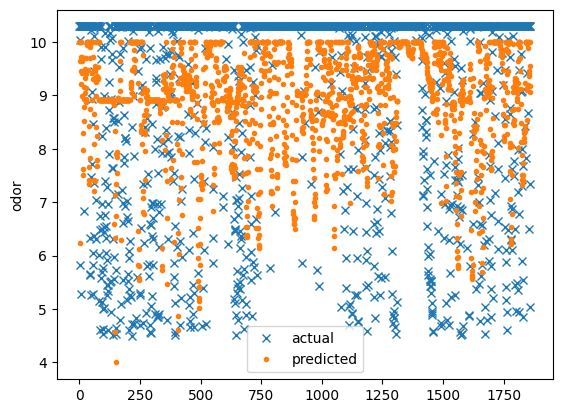

In [61]:
plt.plot(df_test.odor, 'x', label = 'actual')
plt.plot(new_y_pred_mean, 'o', markersize=3, label = 'predicted')
plt.ylabel('odor')
plt.legend()

In [20]:
# # from sklearn.gaussian_process import GaussianProcessRegressor
# # from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.model_selection import GridSearchCV

# # Define the kernel with initial parameters
# kernel = C(1.0, (1e-2, 1e2)) * RBF(1, (1e-2, 1e1))

# # Grid of parameters to search
# param_grid = {
#     'kernel': [C(1.0, (1e-2, 1e2)) * RBF(l, (1e-2, 1e1)) for l in [0.1, 1, 10]],
#     'alpha': [1e-2, 1e-1, 1e0]
# }

# # Initialize the GP regressor
# gp = GaussianProcessRegressor(n_restarts_optimizer=3)

# # Use grid search with cross-validation to find the best parameters
# grid_search = GridSearchCV(gp, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_scaled, y_scaled)

# # Get the best model
# best_gp = grid_search.best_estimator_
# print("Best Kernel: ", best_gp.kernel)
# print("Best Alpha: ", best_gp.alpha)


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/

Best Kernel:  1**2 * RBF(length_scale=10)
Best Alpha:  1.0


In [80]:
folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

# Subsample the combined data for faster training
data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
use_scaler = True  # Set this to False if you don't want to use the scaler

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

# Scale the target values
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

# Define the search space
search_space = [
    Real(1e-3, 1e1, name='alpha', prior='log-uniform'),
    Categorical([0.1, 1, 5, 10, 20], name='length_scale')
]

def objective(params):
    alpha, length_scale = params
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=3)
    return -np.mean(cross_val_score(gp, X_scaled, y_scaled, cv=3, n_jobs=-1, scoring='neg_mean_squared_error'))

res = gp_minimize(objective, search_space, n_calls=50, random_state=42, n_jobs=-1)

best_alpha = res.x[0]
best_length_scale = res.x[1]
best_kernel = C(1.0, (1e-2, 1e2)) * RBF(best_length_scale, (1e-2, 1e1))

# Train the final model with the best parameters
best_gp = GaussianProcessRegressor(kernel=best_kernel, alpha=best_alpha, n_restarts_optimizer=3)
best_gp.fit(X_scaled, y_scaled)

print("Best Kernel: ", best_gp.kernel_)
print("Best Alpha: ", best_alpha)


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-p

Best Kernel:  0.287**2 * RBF(length_scale=0.0656)
Best Alpha:  1.1884175967204555
